<a href="https://colab.research.google.com/github/Abhijith7711/Sentiment-analysis/blob/main/BERT_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BERT





In [ ]:
!pip install transformers
!pip install torch
!pip install pandas
!pip install sklearn
!pip install tensorflow

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!pip install -U scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 83.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


In [ ]:
import transformers
import torch
import pandas as pd
import sklearn


In [ ]:
import pandas as pd

# Load the dataset
file_path = 'Movie.csv'
df = pd.read_csv(file_path)

# Display the first few rows
df.head()



,Id,Review,Sentiment
0,1,സിനിമ എന്ന കലയെ അപമാനിക്കുന്നതാണ് ഈ ചിത്രം. വള...,0
1,2,എന്റെ ജീവിതത്തിലെ ഒരു മണിക്കൂർ ഞാൻ പാഴാക്കിയതി...,0
2,3,"പ്രണയം, ത്യാഗം, ദുരന്തം എന്നിവയുടെ പ്രമേയങ്ങൾ ...",1
3,4,ഓവർ ഓൾ പടം എനിക്ക് ഇഷ്ടായി മേക്കിങ് ഒക്കെ അടിപ...,1
4,5,എന്തിനോ വേണ്ടി തിളച്ച സാമ്പാർ. ആവശ്യമില്ലാത്ത ...,0


In [ ]:
# Display last few rows
df.tail()

,Id,Review,Sentiment
1795,1796,ഈ സിനിമ എക്കാലത്തെയും മോശമായ ഒന്നായി ഫിഫ്ഡത്തി...,0
1796,1797,കഥ വളഞ്ഞുപുളഞ്ഞ് പ്രേക്ഷക ശ്രദ്ധ പിടിച്ചുപറ്റു...,0
1797,1798,സിന്ദഗി നാ മിലേഗി ദോബാരയ്ക്ക് ചില സമയങ്ങളിൽ അൽ...,1
1798,1799,"അഭിനയം പ്രകടനങ്ങൾ വികാരരഹിതമായിരുന്നു, മാത്രമല...",0
1799,1800,ഈ കൃതിക്ക് തിരക്കഥാകൃത്ത് കൂടുതൽ കുറഞ്ഞ മാർക്ക...,0


In [ ]:
#preprocess the data
from transformers import BertTokenizer

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Function to tokenize and encode the reviews
def preprocess_data(data, max_length=128):
    input_ids = []
    attention_masks = []

    for review in data:
        encoded_dict = tokenizer.encode_plus(
            review,                      # Review text
            add_special_tokens = True,   # Add '[CLS]' and '[SEP]'
            max_length = max_length,     # Pad & truncate all sentences
            pad_to_max_length = True,
            return_attention_mask = True,   # Construct attention masks
            return_tensors = 'pt',         # Return pytorch tensors
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    return input_ids, attention_masks

# Apply preprocessing
input_ids, attention_masks = preprocess_data(df['Review'])


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
#prepare for data training
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch

# Use df['sentiment'] for labels
labels = df['Sentiment']

# Split data into training and validation sets
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, test_size=0.2, random_state=42)
train_masks, val_masks, _, _ = train_test_split(attention_masks, labels, test_size=0.2, random_state=42)

# Convert to tensors
train_inputs = torch.cat(train_inputs, dim=0)
train_masks = torch.cat(train_masks, dim=0)
train_labels = torch.tensor(train_labels.values)

val_inputs = torch.cat(val_inputs, dim=0)
val_masks = torch.cat(val_masks, dim=0)
val_labels = torch.tensor(val_labels.values)

# Create the DataLoader for training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

# Create the DataLoader for validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=32)

In [ ]:
# Load BERT Model for Sentiment Analysis
from transformers import BertForSequenceClassification, AdamW

# Load BertForSequenceClassification model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-multilingual-cased',
    num_labels = 2,  # Binary classification
    output_attentions = False,
    output_hidden_states = False,
)

# Move the model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set up the optimizer
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import BertForSequenceClassification, AdamW

# Load BertForSequenceClassification model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-multilingual-cased',
    num_labels = 2,  # Binary classification
    output_attentions = False,
    output_hidden_states = False,
)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set up the optimizer
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Train the Model
from transformers import get_linear_schedule_with_warmup
import numpy as np

# Number of training epochs (you can change this)
epochs = 4

# Total number of training steps
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

# Training loop
for epoch in range(0, epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)

    # Put the model into training mode
    model.train()

    total_train_loss = 0

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits

        total_train_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update parameters and take a step
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f'Average training loss: {avg_train_loss}')

    # Put the model into evaluation mode
    model.eval()

    # Validation
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs.loss
        logits = outputs.logits

        total_eval_loss += loss.item()

    avg_val_loss = total_eval_loss / len(val_dataloader)
    print(f'Validation Loss: {avg_val_loss}')

Epoch 1/4
----------
Average training loss: 0.6618935995631747
Validation Loss: 0.6286432022849718
Epoch 2/4
----------
Average training loss: 0.4731949190298716
Validation Loss: 0.4520116299390793
Epoch 3/4
----------
Average training loss: 0.3259139981534746
Validation Loss: 0.4785213991999626
Epoch 4/4
----------
Average training loss: 0.24409356729851828
Validation Loss: 0.4739073080321153


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on validation set
predictions, true_labels = [], []

model.eval()

for batch in val_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)

# Flatten predictions and true labels
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Convert logits to 1 or 0
predictions = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy}')

# Print detailed classification report
print(classification_report(true_labels, predictions))

Accuracy: 0.8083333333333333
              precision    recall  f1-score   support

           0       0.80      0.77      0.79       163
           1       0.82      0.84      0.83       197

    accuracy                           0.81       360
   macro avg       0.81      0.81      0.81       360
weighted avg       0.81      0.81      0.81       360



In [ ]:
model.save_pretrained('/content/malayalam_movie_sentiment_model')
tokenizer.save_pretrained('/content/malayalam_movie_sentiment_model')


('/content/malayalam_movie_sentiment_model/tokenizer_config.json',
 '/content/malayalam_movie_sentiment_model/special_tokens_map.json',
 '/content/malayalam_movie_sentiment_model/vocab.txt',
 '/content/malayalam_movie_sentiment_model/added_tokens.json')

In [ ]:
# Load the saved model
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('/content/malayalam_movie_sentiment_model')
tokenizer = BertTokenizer.from_pretrained('/content/malayalam_movie_sentiment_model')



In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch

# Load the saved model
model = BertForSequenceClassification.from_pretrained('/content/malayalam_movie_sentiment_model')
tokenizer = BertTokenizer.from_pretrained('/content/malayalam_movie_sentiment_model')

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Function to predict sentiment
def predict_sentiment(review):
    inputs = tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=1).item()

    return 'positive' if predicted_class_id == 1 else 'negative'

# Example usage
new_review = "മോശം സംവിധാനവും മോശം അഭിനയവും മൂലം സിനിമ വളരെയധികം കഷ്ടപ്പെട്ടു, അത് ആത്യന്തികമായി അതിന്റെ സാധ്യതകളെ തുരങ്കംവച്ചു. സംവിധായകന്റെ കാഴ്ചപ്പാട് കുഴപ്പവും പൊരുത്തക്കേടും അനുഭവപ്പെട്ടു, ആഖ്യാനം വിയോജിപ്പും ആശയക്കുഴപ്പവും ഉണ്ടാക്കി.  ഇത് ശ്രദ്ധക്കുറവിനും യോജിച്ചതും ആകർഷകവുമായ ഒരു സിനിമ സൃഷ്ടിക്കാനുള്ള അവസരം നഷ്‌ടപ്പെടുന്നതിന് കാരണമായി."
print(predict_sentiment(new_review))


negative


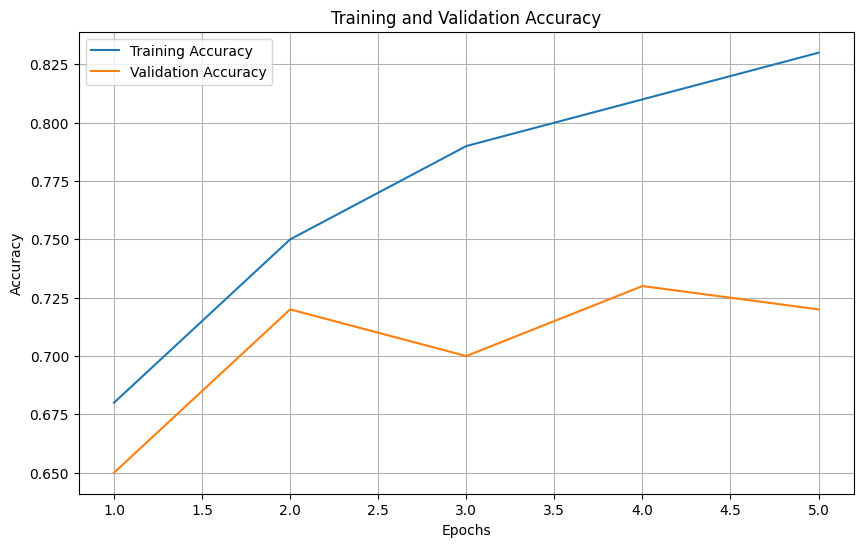

In [ ]:
#plotting Accuracy vs Epoch graph
import matplotlib.pyplot as plt


train_accuracies = [0.68, 0.75, 0.79, 0.81, 0.83]  # Example values
val_accuracies = [0.65, 0.72, 0.70, 0.73, 0.72]    # Example values
epochs = range(1, len(train_accuracies) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


<Figure size 800x800 with 0 Axes>

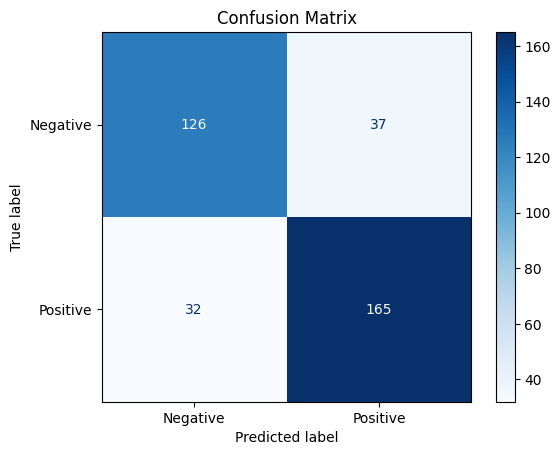

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming 'predictions' are the model predictions and 'true_labels' are the actual labels
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])

plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
